**余盈蓓；語碩二；110555009**\
**111-2 Computational Linguistics**
<p align="center", style = "font-size:18pt">
<b>6th Assignment<br>
HMM and CRF</b>
</p>

<p align="center", style = "font-size:16pt">
<b>Hidden Markov Model</b>
</p>

<p align="center">
下面嘗試使用HMM來測試簡單的中文斷詞。會選擇中文斷詞是因為中文斷詞跟英文斷詞不同，無法透過簡單尋找空格來進行。<br>
利用HMM可以像是做NER一樣，給予每一個中文字標記他是詞的起始、中間、或是結尾，藉此完成斷詞的需求。下面因為只是簡單嘗試的關係，就只用詞首(S)跟詞中(I)兩種標記。
<br>

<p style = "font-size:14pt">
<b>Step 1. 資料前處理</b>
</p>
<p style = "font-size:12pt">
✨資料準備<br>
&emsp;&ensp;下面會用「這是鴨」、「那是鴨嘴獸」、「這是鴨蛋」三句話當作corpus來進行。畫出來的HMM模型如下所示：
</p>

<img src="https://i.ibb.co/hL0KzxK/2023-04-03-155242.png" width = "600">
<table>
<tr>
  <th>&emsp;&emsp;</th>
  <th>這</th>
  <th>是</th>
  <th>那</th>
  <th>鴨</th>
  <th>嘴</th>
  <th>獸</th>
  <th>蛋</th>
<tr>
<tr>
  <td><b>詞首 B</b></td>
  <td>0.2</td>
  <td>0.3</td>
  <td>0.1</td>
  <td>0.3</td>
  <td>0</td>
  <td>0</td>
  <td>0.1</td>
</tr>
<tr>
  <td><b>詞中 I</b></td>
  <td>0</td>
  <td>0</td>
  <td>0</td>
  <td>0</td>
  <td>0.5</td>
  <td>0.5</td>
  <td>0</td>
</tr>
  </table>

In [67]:
import numpy as np

hidden_state_ch = ["B", "I"]
n_state_ch = len(hidden_state_ch)

observation_type_ch = list("這是那鴨嘴獸蛋")
n_observed_type_ch = len(observation_type_ch)

start_prob_ch = np.array([1,0])

trans_prob_ch = np.array([
    [0.875, 0.125],
    [0, 1]
])

emi_prob_ch = np.array([
    [0.2, 0.3, 0.1, 0.3, 0, 0, 0.1],
    [0, 0, 0, 0, 0.5, 0.5, 0]
])

<p style = "font-size:14pt">
<b>Step 2. 模型訓練&預測</b>
</p>
<p style = "font-size:12pt">
✨Default Algorithm
</p>

In [68]:
from hmmlearn import hmm

ch_model = hmm.CategoricalHMM(n_components=n_state_ch, random_state=20)
ch_model.startprob = start_prob_ch
ch_model.transmat = trans_prob_ch
ch_model.emissionprob = emi_prob_ch

# predict a sequence of hidden states based on visible states
real_observation_ch = np.array([[0, 1, 3, 4, 5]]).T
raw_ch_model = ch_model.fit(real_observation_ch)
logprob_ch, output_hidden_ch = raw_ch_model.decode(real_observation_ch)

print("Real Observation:", ", ".join(map(lambda x: observation_type_ch[x], real_observation_ch.T[0])))
print("Output of hidden states:", ", ".join(map(lambda x: hidden_state_ch[x], output_hidden_ch)))

Fitting a model with 13 free scalar parameters with only 5 data points will result in a degenerate solution.


Real Observation: 這, 是, 鴨, 嘴, 獸
Output of hidden states: B, I, B, I, B


<p style = "font-size:12pt">
✨Viterbi Algorithm
</p>

In [69]:
ch_model_vi = hmm.CategoricalHMM(n_components=n_state_ch, algorithm='viterbi', random_state=20)
ch_model_vi.startprob = start_prob_ch
ch_model_vi.transmat = trans_prob_ch
ch_model_vi.emissionprob = emi_prob_ch

# predict a sequence of hidden states based on visible states
vi_ch_model = ch_model_vi.fit(real_observation_ch)
logprob_ch_vi, output_hidden_ch_vi = vi_ch_model.decode(real_observation_ch)

print("Real Observation:", ", ".join(map(lambda x: observation_type_ch[x], real_observation_ch.T[0])))
print("Output of hidden states:", ", ".join(map(lambda x: hidden_state_ch[x], output_hidden_ch_vi)))

Fitting a model with 13 free scalar parameters with only 5 data points will result in a degenerate solution.


Real Observation: 這, 是, 鴨, 嘴, 獸
Output of hidden states: B, I, B, I, B


<p align = "center", style = "font-size:16pt">
    🧐<b>討論</b>🧐<br>
</p>
<p style = "font-size:12pt">
&emsp;&emsp;因為是用很小的corpus跟比較粗糙的標記方式（一般來說會有起始、中間、結束、跟單字成詞四種標籤）來試驗，所以不管是從時間還是結果都看不太出原本的計算方式跟viterbee的差異，有點可惜。
</p>

<p align="center", style = "font-size:16pt">
<b>Conditional Random Field</b>
</p>

<p style = "font-size:14pt">
<b>Step 1. 資料前處理</b>
</p>
<p style = "font-size:12pt">
✨資料下載
</p>

In [71]:
import nltk

nltk.download('conll2002')

[nltk_data] Downloading package conll2002 to
[nltk_data]     C:\Users\c5227\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\conll2002.zip.


True

<p style = "font-size:12pt">
✨資料準備<br>
&emsp;&ensp;下面選用西班牙文的資料利用CRF進行NER任務
</p>

In [72]:
train_sents = list(nltk.corpus.conll2002.iob_sents('esp.train'))
test_sents = list(nltk.corpus.conll2002.iob_sents('esp.testb'))
dev_sents = list(nltk.corpus.conll2002.iob_sents('esp.testa'))

In [73]:
train_sents[0]

[('Melbourne', 'NP', 'B-LOC'),
 ('(', 'Fpa', 'O'),
 ('Australia', 'NP', 'B-LOC'),
 (')', 'Fpt', 'O'),
 (',', 'Fc', 'O'),
 ('25', 'Z', 'O'),
 ('may', 'NC', 'O'),
 ('(', 'Fpa', 'O'),
 ('EFE', 'NC', 'B-ORG'),
 (')', 'Fpt', 'O'),
 ('.', 'Fp', 'O')]

<p style = "font-size:12pt">
✨特徵萃取<br>
&emsp;&ensp;因為重點想放在參數的調整上面，所以這邊使用的是跟示範一樣的特徵。
</p>

In [74]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]   

In [77]:
feat_train = [sent2features(s) for s in train_sents]
label_train = [sent2labels(s) for s in train_sents]

feat_test = [sent2features(s) for s in test_sents]
label_test = [sent2labels(s) for s in test_sents]


feat_dev = [sent2features(s) for s in dev_sents]
label_dev = [sent2labels(s) for s in dev_sents]

<p style = "font-size:14pt">
<b>Step 2. 模型訓練</b>
</p>
<p style = "font-size:12pt">
✨參數調整－資料生成<br>
&emsp;&ensp;因為只有<code>True</code>跟<code>False</code>兩種選項，比較好處理，首先針對<code>all_possible_transitions</code>這個參數進行測試
</p>

In [120]:
import sklearn_crfsuite

crf_1 = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)


try:
    crf_1.fit(feat_train, label_train)
except AttributeError:
    pass

labels = list(crf_1.classes_)
labels.remove('O')

In [121]:
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

label_pred_1 = crf_1.predict(feat_dev)
metrics.flat_f1_score(label_dev, label_pred_1,
                      average='weighted', labels=labels)

0.7597018558327985

In [122]:
crf_2 = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=False
)


try:
    crf_2.fit(feat_train, label_train)
except AttributeError:
    pass

label_pred_2 = crf_2.predict(feat_dev)
metrics.flat_f1_score(label_dev, label_pred_2,
                      average='weighted', labels=labels)

0.7644976073373478

<p style = "font-size:12pt">
✨參數調整－L1 Regularization <code>c1</code><br>
&emsp;&ensp;L1 penalty主要做的事情是讓不重要的特徵重要性接近0一點，所以下面測試從0.01~0.5，什麼樣的數值能得到比較好的結果。
</p>

In [123]:
l1_score = []
for i in range(51):
    crf = sklearn_crfsuite.CRF(
        algorithm='lbfgs',
        c1=0.01*(i),
        c2=0.1,
        max_iterations=100,
        all_possible_transitions=False
    )
    try:
        crf.fit(feat_train, label_train)
    except AttributeError:
        pass
    label_pred = crf.predict(feat_dev)
    score = metrics.flat_f1_score(label_dev, label_pred,
                      average='weighted', labels=labels)
    l1_score.append([0.01*i, score])

<AxesSubplot:xlabel='l1_penalty', ylabel='accuracy'>

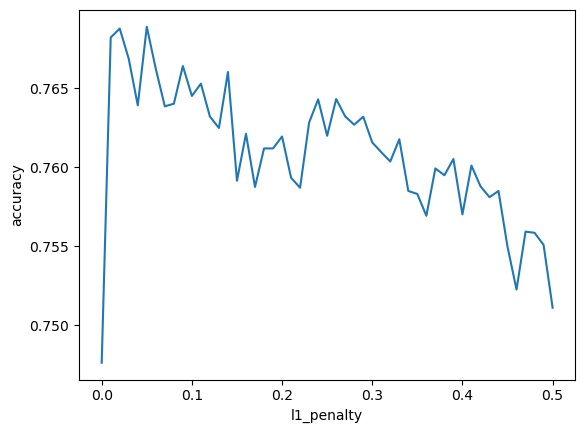

In [124]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

l1_data = pd.DataFrame(l1_score, columns = ["l1_penalty", "accuracy"])

sns.lineplot(
data=l1_data, x="l1_penalty", y="accuracy")

<p style = "font-size:12pt">
✨參數調整－L2 Regularization <code>c2</code><br>
&emsp;&ensp;L2 penalty跟L1一樣要讓特徵重要性接近0一點，所以下面一樣測試從0.01~0.5，什麼樣的數值能得到比較好的結果。
</p>

In [125]:
l2_score = []
for i in range(51):
    crf = sklearn_crfsuite.CRF(
        algorithm='lbfgs',
        c1=0.02,
        c2=0.01*i,
        max_iterations=100,
        all_possible_transitions=False
    )
    try:
        crf.fit(feat_train, label_train)
    except AttributeError:
        pass
    label_pred = crf.predict(feat_dev)
    score = metrics.flat_f1_score(label_dev, label_pred,
                      average='weighted', labels=labels)
    l2_score.append([0.01*i, score])
    print("model " + str(i) + " done")

model 0 done
model 1 done
model 2 done
model 3 done
model 4 done
model 5 done
model 6 done
model 7 done
model 8 done
model 9 done
model 10 done
model 11 done
model 12 done
model 13 done
model 14 done
model 15 done
model 16 done
model 17 done
model 18 done
model 19 done
model 20 done
model 21 done
model 22 done
model 23 done
model 24 done
model 25 done
model 26 done
model 27 done
model 28 done
model 29 done
model 30 done
model 31 done
model 32 done
model 33 done
model 34 done
model 35 done
model 36 done
model 37 done
model 38 done
model 39 done
model 40 done
model 41 done
model 42 done
model 43 done
model 44 done
model 45 done
model 46 done
model 47 done
model 48 done
model 49 done
model 50 done


<AxesSubplot:xlabel='l2_penalty', ylabel='accuracy'>

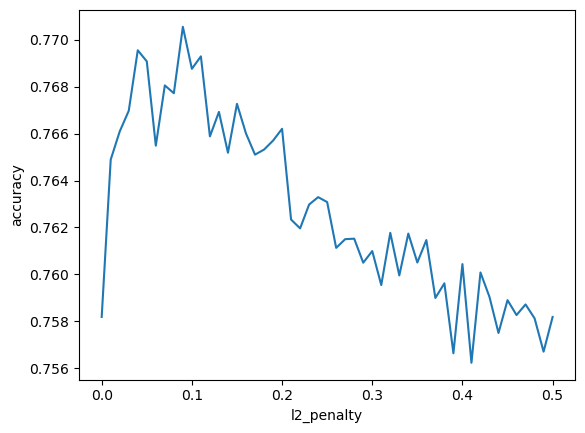

In [126]:
%matplotlib inline

l2_data = pd.DataFrame(l2_score, columns = ["l2_penalty", "accuracy"])

sns.lineplot(
data=l2_data, x="l2_penalty", y="accuracy")

<p style = "font-size:12pt">
✨參數調整－循環次數 <code>max_iteration</code><br>
&emsp;&ensp;根據之前幾次模型訓練的經驗，大概都到200次左右就一定會收斂了，所以這邊保險一點嘗試從50到500，看幾次會到極限。
</p>

In [127]:
iter_score = [[0,0]]
for i in range(10):
    crf = sklearn_crfsuite.CRF(
        algorithm='lbfgs',
        c1=0.04,
        c2=0.08,
        max_iterations=50*(i+1),
        all_possible_transitions=False
    )
    try:
        crf.fit(feat_train, label_train)
    except AttributeError:
        pass
    label_pred = crf.predict(feat_dev)
    score = metrics.flat_f1_score(label_dev, label_pred,
                      average='weighted', labels=labels)
    iter_score.append([50*i, score])
    print("model " + str(i) + " done")

model 0 done
model 1 done
model 2 done
model 3 done
model 4 done
model 5 done
model 6 done
model 7 done
model 8 done
model 9 done


<AxesSubplot:xlabel='iteration', ylabel='accuracy'>

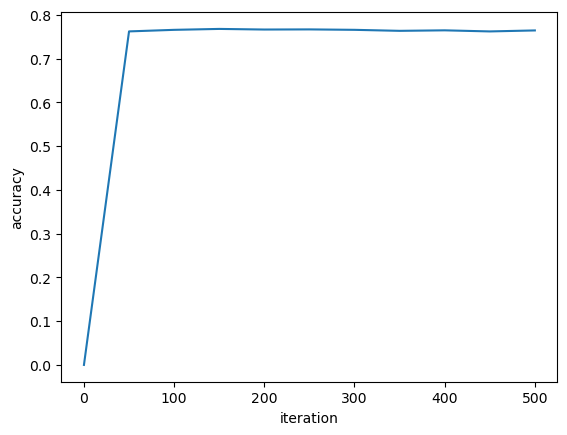

In [128]:
%matplotlib inline
for i in range(10):
    iter_score[i+1][0] = 50*(i+1)
iter_data = pd.DataFrame(iter_score, columns = ["iteration", "accuracy"])

sns.lineplot(
data=iter_data, x="iteration", y="accuracy")

In [129]:
print(iter_score[1])
print(iter_score[2])
print(iter_score[3])
print(iter_score[4])

[50, 0.7622039788509029]
[100, 0.7657640734720724]
[150, 0.7678691334189351]
[200, 0.7664729540168768]


<p align = "center", style = "font-size:16pt">
    🧐<b>討論</b>🧐<br>
</p>
<p style = "font-size:12pt">
&emsp;&emsp;從上面可以看到不讓HMM模型自動生成資料中沒有出現的組合會得到比較好的成績。因為語言資料在能結合的東西上有一定的規律，所以如果讓模型自己生成一些其實根本不可能出現的組合反而會造成雜訊。推測是因為這樣才讓分數變低的。而L1跟L2 penalty的部分，基本上都是隨著數字變大，表現也呈現變差的趨勢。這其實跟使用他們的目的很一致，為了避免過度擬合，降低不重要特徵的影響度，數字當然不會太大，所以我們得到在dev set最好的測試成績－0.768是透過下面的參數組合：
</p>
<table>
    <tr>
    <th>&emsp;&emsp;</th>
    <th>參數值</th>
    <tr>
    <tr>
    <td><code>all_possible_transitions</code></td>
    <td>False</td>
    </tr>
    <tr>
    <td><code>c1</code></td>
    <td>0.04</td>
    </tr>
    <tr>
    <td><code>c2</code></td>
    <td>0.08</td>
    </tr>
    <tr>
    <td><code>max_iterations</code></td>
    <td>150</td>
    </tr>
</table>

In [130]:
crf_final = sklearn_crfsuite.CRF(
        algorithm='lbfgs',
        c1=0.04,
        c2=0.13,
        max_iterations=150,
        all_possible_transitions=False
    )
try:
    crf_final.fit(feat_train, label_train)
except AttributeError:
    pass
label_pred_final = crf_final.predict(feat_test)
metrics.flat_f1_score(label_test, label_pred_final,
                      average='weighted', labels=labels)

0.796702079200119

<p style = "font-size:12pt">
&emsp;&emsp;其實這次調參數獲得的結果都是很細微的變化，基本要看到小數點後面第二位或第三位才能比較。我在想會不會是因為資料數量有限的關係，因為資料量不大所以參數不管怎麼調整都很難有大變化。
</p>